### PREPARATION

In [1]:
!pip install autokeras
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import autokeras as ak

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-07 14:44:27.749521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 14:44:32.783027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 14:44:32.783084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 14:44:32.806526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

Using TensorFlow backend


In [3]:
DATA_PATH = "data/ctudata.csv"
LABEL_PATH = "data/ctulabel.csv"

early_warning = pd.read_csv(DATA_PATH)
rotulos = pd.read_csv(LABEL_PATH)

init = 441
train = 2642
test = 5632
cols = ["5_kurt_total_ips_origem", 
        "5_skw_total_ips_destino", 
        "5_voefficient_variation_total_pacotes"]

In [4]:
x_train = early_warning[cols][init:train]
y_train = rotulos['maior_2'][init:train]

x_test = early_warning[cols][train:test]
y_test = rotulos['maior_2'][train:test]

x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)

### LOAD MODEL

In [5]:
from tensorflow.keras.models import load_model
MODEL_PATH = "models/ctumodel"
loaded_model = load_model(MODEL_PATH, custom_objects=ak.CUSTOM_OBJECTS, compile=False)
#keras.utils.plot_model(loaded_model, show_shapes=True)

2024-03-07 14:44:50.861662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 14:44:50.862600: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### RECONSTRUCTION

In [6]:
Xtrain = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
X_pred_train = loaded_model.predict(Xtrain)
X_pred_train = pd.DataFrame(X_pred_train, columns=x_train.columns, index=x_train.index)
X_pred_train.index = x_train.index
X_pred_train

69/69 [==============================] - 4s 3ms/step


,5_kurt_total_ips_origem,5_skw_total_ips_destino,5_voefficient_variation_total_pacotes
441,0.372685,0.593216,0.439798
442,0.378977,0.594587,0.439207
443,0.372892,0.593261,0.439778
444,0.379147,0.594624,0.439191
445,0.376692,0.594089,0.439421
...,...,...,...
2637,1.160890,0.712168,0.414150
2638,1.162779,0.712355,0.414178
2639,1.166062,0.712681,0.414226
2640,1.179407,0.714004,0.414420


Text(0.5, 1.0, 'Modelo de treinamento')

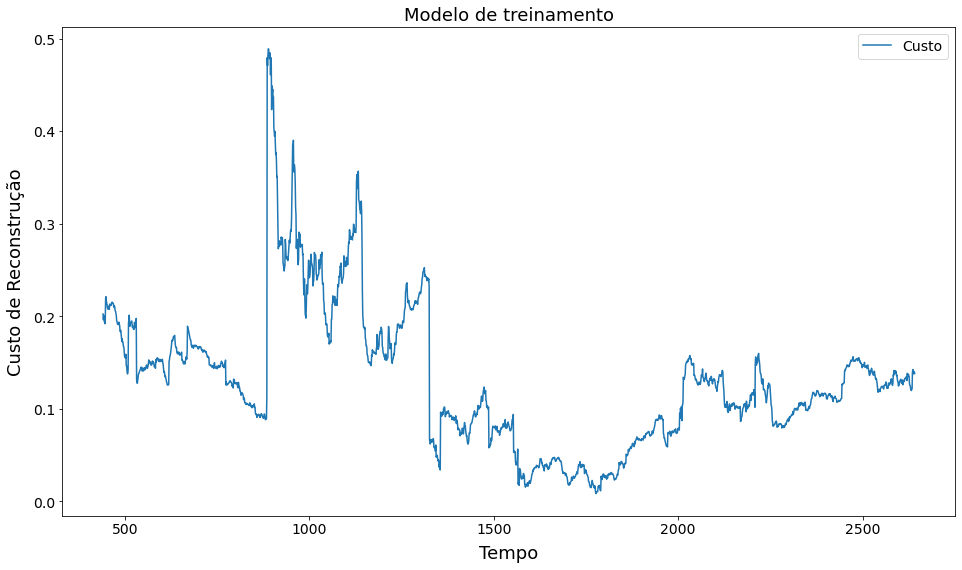

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)

ax.plot(np.mean(np.abs(X_pred_train-x_train), axis=1), label='Custo')
plt.xlabel("Tempo", fontsize=18, labelpad=8.0)
plt.ylabel("Custo de Reconstrução", fontsize=18, labelpad=8.0)
leg = ax.legend(prop={"size":14})

plt.title("Modelo de treinamento", fontsize=18)

In [8]:
# scored_train = pd.DataFrame()
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-x_train), axis = 1)

# plt.figure(figsize=(10,6), dpi=80)
# plt.title('Distribuição do Custo de Reconstrução', fontsize=22)
# sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy')
# sns.set(font_scale=1.4)
# plt.xlim([0.0,0.7])
# plt.xlabel("Reconstruction Cost", fontsize=18, labelpad=8.0)
# plt.ylabel("Density", fontsize=18, labelpad=8.0)

### TEST

In [9]:
threshold = 4.75

Xtest = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])
X_pred_test = loaded_model.predict(Xtest)
X_pred_test = pd.DataFrame(X_pred_test, columns=x_test.columns)

scored_test = pd.DataFrame()
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
scored_test['Anomaly'] = scored_test['Loss_mae'] > threshold

concatenated = scored_test.copy()
concatenated.index = y_test.index
concatenated['label'] = y_test
concatenated['label'] = concatenated['label'].astype(int)
concatenated

94/94 [==============================] - 0s 3ms/step


,Loss_mae,Anomaly,label
2642,0.137478,False,0
2643,0.136494,False,0
2644,0.133521,False,0
2645,0.131504,False,0
2646,0.132505,False,0
...,...,...,...
5627,0.061111,False,0
5628,0.060851,False,0
5629,0.057625,False,0
5630,0.057241,False,0


In [10]:
xticklabels=['Normal', 'Anomalia'] 
yticklabels=['Normal', 'Anomalia']
# cm = confusion_matrix(concatenated['label'], concatenated['Anomaly'])
# s = sns.heatmap(cm, annot=True, fmt='d', xticklabels=xticklabels, yticklabels=yticklabels)
# s.set(xlabel='Valor Predito', ylabel='Valor Real', title=f"Threshold {threshold}")
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(concatenated["label"], concatenated["Anomaly"]))
print(classification_report(concatenated["label"], concatenated["Anomaly"], digits=4))

[[2930   20]
 [  39    1]]
              precision    recall  f1-score   support

           0     0.9869    0.9932    0.9900      2950
           1     0.0476    0.0250    0.0328        40

    accuracy                         0.9803      2990
   macro avg     0.5172    0.5091    0.5114      2990
weighted avg     0.9743    0.9803    0.9772      2990



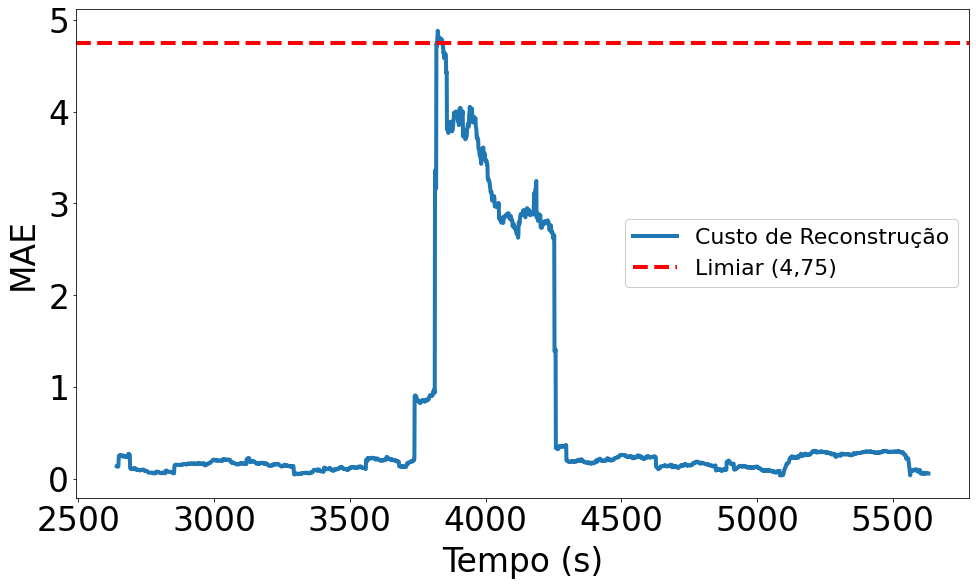

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.style.use('classic')

fsize = 33

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)

erro = [np.nan] * train
erro.extend(np.mean(np.abs(X_pred_test-Xtest), axis=1))

ax.plot(erro, linewidth=4, label='Custo de Reconstrução')

plt.axhline(y=threshold, linewidth=4, color="r", linestyle="--", label="Limiar (4,75)")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel("Tempo (s)", fontsize=fsize, labelpad=8.0)
plt.ylabel("MAE", fontsize=fsize, labelpad=8.0)
plt.legend(fontsize=fsize-11, loc="center right", framealpha=1)

plt.savefig("custo51.pdf", pad_inches=0, bbox_inches='tight', transparent=True)